In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

# 1 Можно ли отобрать наиболее значимые признаки с помощью PCA? Ответ объясните.

Метод главных компонент PCA - это способ уменьшения размерности данных с сохранением максимально возможного количества информации. Он аппроксимирует n-размерное облако наблюдений до эллипсоида (тоже n-мерного), полуоси которого и будут являться будущими главными компонентами. Вот интересная [статья о работе метода](https://habr.com/ru/post/304214/).

![PCA_figure.jpg](https://ltdfoto.ru/images/2023/03/09/PCA_figure.jpg)

Получаемые в результате признаки - это уже не те признаки, что были изначально. Новые признаки фактически теряют "читаемость" с точки рения человека, именно поэтому говорить о том, что с помощью PCA можно отобрать наиболее значимые признаки некорректно.

Получить новые оси-компоненты на основе старых признаков - можно

Отобрать наиболее значимые признаки из изначальных - нет

# 2 Написать свою реализацию метода главных компонент с помощью сингулярного разложения с использованием функции numpy.linalg.svd(). Применить к данным на уроке и сравнить ответы.

Работать будем с ирисами, как на уроке:

In [2]:
iris = datasets.load_iris()
X = iris.data
X.shape

(150, 4)

In [3]:
X_ = X.astype(float)
rows, cols = X_.shape

# центрирование - вычитание из каждого значения среднего по признаку
means = X_.mean(axis=0)
for i in range(rows):
    for j in range(cols):
        X_[i, j] -= means[j]

# деление каждого значения на стандартное отклонение
std = np.std(X_, axis=0)
for j in range(cols):
    for i in range(rows):
        X_[i, j] /= std[j]

Вот код реализации метода с урока:

In [4]:
# Найдем собственные векторы и собственные значения
covariance_matrix = X_.T.dot(X_)
eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# print('Собственные значения в порядке убывания:')
# for i in eig_pairs:
#     print(i[0])
    
eig_sum = sum(eig_values)
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(f'Доля дисперсии, описываемая каждой из компонент \n{var_exp}\n'
      f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}\n')

# Сформируем вектор весов из собственных векторов, соответствующих первым двум главным компонентам
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))

print(f'Матрица весов W:\n', W)

Доля дисперсии, описываемая каждой из компонент 
[72.96244541329986, 22.85076178670179, 3.668921889282866, 0.517870910715483]
Кумулятивная доля дисперсии по компонентам 
[ 72.96244541  95.8132072   99.48212909 100.        ]

Матрица весов W:
 [[ 0.52106591 -0.37741762]
 [-0.26934744 -0.92329566]
 [ 0.5804131  -0.02449161]
 [ 0.56485654 -0.06694199]]


_______
_______

А вот реализация с помощью сингулярного разложения матриц ```SVD```, согласно которому марицу можно представить в виде произведения трёх матриц $X = UDV^T$, где:
- $U$ - собственные векторы матрицы $XX^T$
- $V$ - собственные векторы матрицы $X^TX$
- по диагонали матрицы $D$ - собственные значения (сингулярные числа) матриц $XX^T$ и $X^TX$

нам нужен $V$, только не транспонированный:

In [5]:
def get_own_vector(X, k):
    U, D, V = np.linalg.svd(X)
    V = V.T[:, :k]
    return X@V, V

In [6]:
svd_z, svd_w = get_own_vector(X_, 2)
print(f'Матрица весов PCA_SVD:\n {svd_w}')

Матрица весов PCA_SVD:
 [[ 0.52106591 -0.37741762]
 [-0.26934744 -0.92329566]
 [ 0.5804131  -0.02449161]
 [ 0.56485654 -0.06694199]]


Сраавним матрицы весов. Матрица ```W``` получена вычислением собственных векторов и собственных значений ковариационной матрицы исходных данных, а матрица ```svd_w``` - сингулярным разложением матрицы данных. т.е. тип данных float, то из-за погрешностей вычисления немного они всё же друг от друга отличаются, но только начиная с 15-го знака после запятой:

In [7]:
print('равны') if np.array_equal(np.round(W, 14), np.round(svd_w, 14)) else print('не равны')

равны


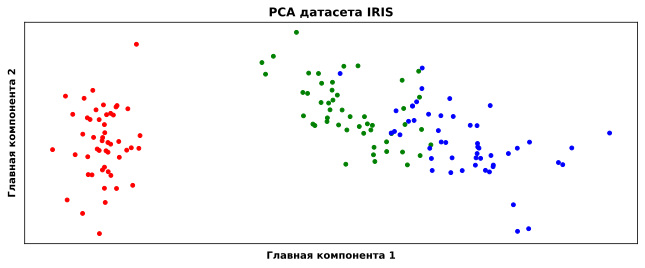

In [8]:
plt.figure(figsize=(11, 4))
y = iris.target
for c, i in zip('rgb', [0, 1, 2]):
    plt.scatter(svd_z[y==i, 0], svd_z[y==i, 1], c=c, s=15)
plt.xticks([])
plt.yticks([])
plt.xlabel('Главная компонента 1', fontweight='bold')
plt.ylabel('Главная компонента 2', fontweight='bold')
plt.title('PCA датасета IRIS', fontweight='bold');

# 3 Обучить любую модель классификации (из рассмотренных в курсе) на датасете IRIS до применения PCA и после него. Сравнить качество классификации по отложенной выборке.

используем алгоримт случайного леса, написанный к пятому дз. Сам код алгоритма лежит в ```dz_8_random_forest.ipynb```

In [9]:
%run ./dz_8_random_forest.ipynb

In [10]:
iris_accuracy, PCA_iris_accuracy = [], []

for i in range(1, 21):
    my_forest, OOB_accuracy = random_forest(iris.data, y, n_trees=i, depth=3)
    iris_accuracy.append(accuracy_metric(y, tree_vote(my_forest, iris.data)))
    
    my_forest, OOB_accuracy = random_forest(svd_z, y, n_trees=i, depth=3)
    PCA_iris_accuracy.append(accuracy_metric(y, tree_vote(my_forest, svd_z)))    

In [11]:
range(1, len(iris_accuracy)+1)

range(1, 21)

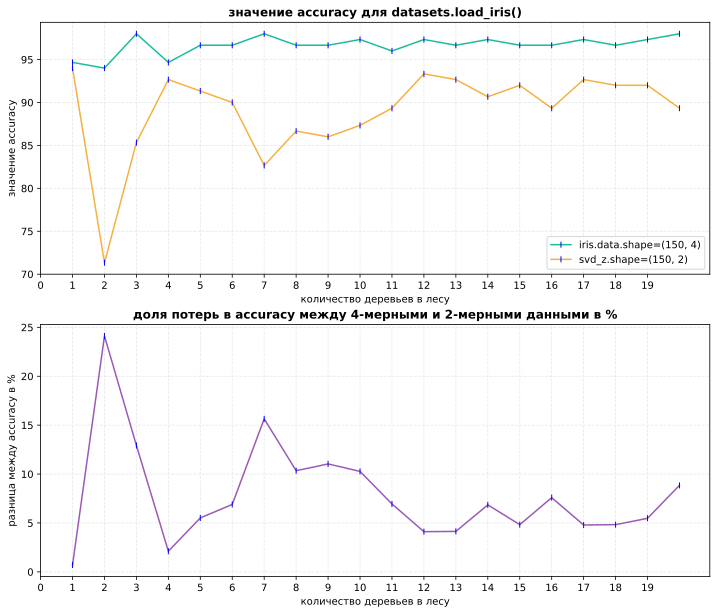

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
ax1, ax2 = ax.flatten()

ax1.plot(range(1, len(iris_accuracy)+1), iris_accuracy,
         '-|', mec='b', c='#1ABC9C', label=f'{iris.data.shape=}')
ax1.plot(range(1, len(PCA_iris_accuracy)+1), PCA_iris_accuracy,
         '-|', mec='b', c='#F5B041', label=f'{svd_z.shape=}')
ax1.set_title('значение accuracy для datasets.load_iris()', fontweight='bold')
ax1.set_xlabel('количество деревьев в лесу')
ax1.set_ylabel('значение accuracy')
ax1.legend()
ax1.set_xticks(range(len(iris_accuracy)))
ax1.grid(linestyle = '--', c='#E5E8E8')


ax2.plot(range(1, len(iris_accuracy)+1), 
         100-(np.array(PCA_iris_accuracy) / np.array(iris_accuracy))*100, '-|',  mec='b', c='#9B59B6')
ax2.set_title('доля потерь в accuracy между 4-мерными и 2-мерными данными в %', fontweight='bold')
ax2.set_xlabel('количество деревьев в лесу')
ax2.set_ylabel('разница между accuracy в %')
ax2.set_xticks(range(len(PCA_iris_accuracy)))
ax2.grid(linestyle = '--', c='#E5E8E8')

fig.set_size_inches(12,10);

По графикам мы можем видеть, что значение accuracy после применения PCA несколько ниже, но с увеличением количества деревьев доля потери снижается и после 5-ти деревьев редко выходит за 10%, а значит применение метода PCA действительно целесообразно в тех ситуациях, когда эта важно (например, при очень большом количество признаков)

# 4 Принять участие в одном из соревнований и прислать свой псевдоним на Kaggle и ссылку на github с решением задачи:

участвовал в [соревновании по классификации](https://www.kaggle.com/competitions/choose-tutors/leaderboard). За основу взял код одного из участников, поигрался с гиперпараметрами и получил вот такой результат:

![kaggle_best.jpg](https://ltdfoto.ru/images/2023/03/09/kaggle_best.jpg)

файл с кодом: *dz_8_kaggle_choose tutors.ipynb*

файл с предсказанием: *Solin_predictions.csv*